<a href="https://colab.research.google.com/github/ymirandan/projetosPython/blob/main/Previsoes_SVR_Serie_Temporal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contexto

Neste notebook temos o intuito de fazer previsões para uma determinada métrica.

Vamos considerar que uma empresa está observando a **Taxa de Satisfação** (%) de seus clientes desde 2022 e gostaria de projetar esses valores para 2025. Ela não possui outras variáveis que ajudem a explicar esse *KPI*, por isso, faremos a análise da série temporal.

Para tanto, vamos gerar uma base de dados aleatória e aplicar o algoritmo *SVR*.

Análise feita por Yasmin de Miranda Nobre, 16/06/2025

# Importando bibliotecas

In [550]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import random

from scipy.stats import norm
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import resample
from datetime import date

# Gerando Base de Dados

In [551]:
SEED=472393
np.random.seed(SEED)
random.seed(SEED)

periodo = pd.date_range(start='2022-01-01', end='2024-12-01',freq='MS')

taxa_satisfacao = norm.rvs(loc=45,scale=6, size=len(periodo))
taxa_satisfacao = np.round(taxa_satisfacao,2)

base_dados = pd.DataFrame({
   'Data' : periodo,
   'Taxa de Satisfação' : taxa_satisfacao
})


In [552]:
fig = px.line(base_dados, x="Data", y="Taxa de Satisfação")


fig.update_layout(title="Histórico da Taxa de Satisfação dos Clientes na Empresa",
    xaxis_title="",
    yaxis_title="(%)",
     font=dict(size=17))

fig.show()

Desse modo, iremos dividir a base em treino e teste, treinar e validar o modelo, e em seguida fazer as previsões para 2025.

# Treinando Modelo

Como o periodo observado é "curto" (temos apenas 2 anos de dados), vamos separar 70% da base para treinar e 30% para testar.

In [553]:
percentual_teste = 0.7

loc_ultima_data_treino = int(len(periodo)*percentual_teste)

ultima_data_treino = base_dados.iloc[loc_ultima_data_treino-1,0]
#como o python irá selecionar as linhas que vão do index 0 até loc_ultima_data_treino,
#precisamos retirar 1 unidade do loc_ultima_data_treino para saber qual será a ultima data que estará no treino

print(f"Iremos Treinar de 2022-01-01 até", ultima_data_treino.date(),f".\nIremos testar os valores de março a dezembro de 2024.")

Iremos Treinar de 2022-01-01 até 2024-01-01 .
Iremos testar os valores de março a dezembro de 2024.


In [554]:
treino = base_dados.iloc[:loc_ultima_data_treino,1]

teste = base_dados.iloc[loc_ultima_data_treino:,1]

## Redimensionando os Dados

Para utilizar o algoritmo *SVR* precisamos redimensionar os dados. Nesse sentido devemos avaliar sua distribuição e optar pelo *MinMaxScaler* ou *StandardScaler*.

Por termos gerado os dados de uma distribuição normal, já sabemos qual o comportamento da série. Asssim, iremos transformar os dados com o *StandardScaler*.

In [555]:
scaler = StandardScaler()

treino_escalado = scaler.fit_transform(treino.to_numpy().reshape(-1,1)).flatten()
teste_escalado = scaler.transform(teste.to_numpy().reshape(-1,1)).flatten()

treino_escalado

array([ 1.06137632, -0.1020456 ,  0.31554628,  0.13683884,  0.98661096,
        0.6784318 , -1.16881961, -0.92264099,  1.02125833,  1.65767564,
        0.39213519, -0.58346156, -1.35117415, -1.21623179,  0.99390515,
       -0.19139932,  0.10583857,  0.3884881 , -1.26182042,  1.58473383,
        0.6984908 , -1.16334898, -2.27571163,  0.39942937, -0.18410514])

## Criando Funções de Auxilio

Iremos utilizar os dados anteriores (*lags*) como preditoras. Por isso, iremos criar uma função para qual passaremos os valores e os *lags* desejados e ela retornará o conjunto com o dado original e qual seu *lag* correspondente.

In [556]:
def criar_lags(serie, lags):
    X, y = [], []
    for i in range(max(lags), len(serie)):
        lagged_values = [serie[i - lag] for lag in lags]
        X.append(lagged_values)
        y.append(serie[i])
    return np.array(X), np.array(y)


Além disso, também criaremos uma função para testar o desempenho do *SVR* com algumas combinações de lags. A função vai retornar um *DataFrame* com as métricas *RMSE* e *MAE* de teste de cada modelo, o que irá sugerir com quais *lags* iniciar a modelagem.

O intuito dessa função é apenas nortear a análise. Os parametros do *SVR* serão encontrados de modo otimizado por GridSearchCV

In [557]:
def testar_lags(treino_escalado,teste_escalado, combinacoes_lags):
    resultados = []

    for lags in combinacoes_lags:
        X_treino, y_treino = criar_lags(treino_escalado, lags)
        X_teste, y_teste = criar_lags(teste_escalado, lags)

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('svr', SVR())
        ])

        param_grid = {
          'svr__C':[0.1,1,10,50,100],
          'svr__gamma':['scale','auto',0.01,0.1,1],
          'svr__epsilon':[0.001,0.01,0.1,0.2]
        }

        tscv = TimeSeriesSplit(n_splits=3)

        grid_search = GridSearchCV(
            pipeline,
            param_grid,
            cv=tscv,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1
        )

        grid_search.fit(X_treino, y_treino)

        y_pred = grid_search.predict(X_teste)

        scaler = StandardScaler().fit(y_treino.reshape(-1, 1))
        y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1))
        y_teste_original = scaler.inverse_transform(y_teste.reshape(-1, 1))

        rmse = root_mean_squared_error(y_teste_original, y_pred_original)
        mae = mean_absolute_error(y_teste_original, y_pred_original)

        resultados.append({
            'Lags': lags,
            'Melhores Parâmetros': grid_search.best_params_,
            'RMSE Validação Cruzada': -grid_search.best_score_ ,
            'RMSE Teste': rmse,
            'MAE Teste': mae
            })

    df_resultados = pd.DataFrame(resultados)
    return df_resultados.sort_values('RMSE Teste').reset_index(drop=True)

## Análise Inicial

In [558]:
combinacoes = [
    [1,3,6],
    [1,3,9],
    [1,4,6],
    [1,4,9],
    [1,6,9],
    [2,4,6],
    [2,4,9]
]
#aqui, basicamente estamos considerando quantos meses atrás estariam influenciando os dados
#exemplo: a taxa de satisfação de janeiro será explicada pela de dezembro (mes anterior,1), outubro (3) e julho (6)

resultados = testar_lags(treino_escalado, teste_escalado, combinacoes)
resultados

,Lags,Melhores Parâmetros,RMSE Validação Cruzada,RMSE Teste,MAE Teste
0,"[2, 4, 6]","{'svr__C': 1, 'svr__epsilon': 0.2, 'svr__gamma...",0.946248,0.677423,0.581608
1,"[1, 6, 9]","{'svr__C': 0.1, 'svr__epsilon': 0.2, 'svr__gam...",1.100803,0.778581,0.778433
2,"[2, 4, 9]","{'svr__C': 1, 'svr__epsilon': 0.2, 'svr__gamma...",1.080612,0.790463,0.772568
3,"[1, 4, 6]","{'svr__C': 1, 'svr__epsilon': 0.2, 'svr__gamma...",1.136569,0.957905,0.818113
4,"[1, 3, 6]","{'svr__C': 10, 'svr__epsilon': 0.2, 'svr__gamm...",1.030504,1.155012,1.046388
5,"[1, 3, 9]","{'svr__C': 50, 'svr__epsilon': 0.001, 'svr__ga...",1.075308,1.180402,1.055198
6,"[1, 4, 9]","{'svr__C': 1, 'svr__epsilon': 0.2, 'svr__gamma...",1.082946,1.394721,1.362599


### Testando Lags 2,4,6

In [559]:
resultados.iloc[0,0]

[2, 4, 6]

In [560]:
lags_satisfacao = resultados.iloc[0,0]

X_treino_satisfacao, y_treino_satisfacao = criar_lags(treino_escalado, lags_satisfacao)
X_teste_satisfacao, y_teste_satisfacao = criar_lags(teste_escalado, lags_satisfacao)

modelo_satisfacao = SVR(kernel='rbf', C=resultados.iloc[0,1].get('svr__C'),
                        gamma= resultados.iloc[0,1].get('svr__gamma'),
                        epsilon=resultados.iloc[0,1].get('svr__epsilon'))

modelo_satisfacao.fit(X_treino_satisfacao,y_treino_satisfacao)

y_pred = modelo_satisfacao.predict(X_teste_satisfacao)
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_teste_original = scaler.inverse_transform(y_teste_satisfacao.reshape(-1, 1))

rmse = root_mean_squared_error(y_teste_original, y_pred_original)
mae = mean_absolute_error(y_teste_original, y_pred_original)
print('RMSE de Teste: %.2f' % rmse)
print('\nMAE de Teste: %.2f' % mae)

RMSE de Teste: 3.33

MAE de Teste: 2.85


#### Previsoes 2024

Iremos prever os dados de Fev/24 até Dez/24 e compará-los com nosso conjunto de Teste. Além disso vamos construir um Intervalo de Confiança (**IC**) a 95% para essas previsões. Utilizaremos o **IC** *Bootstrap*.

In [561]:
n_previsoes_fut = 11
datas_prev = pd.date_range(start="2024-02-01", periods=n_previsoes_fut, freq="MS")
datas_prev

DatetimeIndex(['2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01',
               '2024-06-01', '2024-07-01', '2024-08-01', '2024-09-01',
               '2024-10-01', '2024-11-01', '2024-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [562]:
ultimos_satisfacao = treino_escalado[-max(lags_satisfacao):].tolist()

In [563]:
futuros_satisfacao = []

for _ in range(n_previsoes_fut):
    input_modelo_satisfacao = [ultimos_satisfacao[-lag] for lag in lags_satisfacao]

    previsao_escalado_satisfacao = modelo_satisfacao.predict([input_modelo_satisfacao])[0]

    previsao_satisfacao = scaler.inverse_transform(np.array(previsao_escalado_satisfacao).reshape(-1, 1)).flatten()[0]

    futuros_satisfacao.append(previsao_satisfacao)

    ultimos_satisfacao.append(previsao_escalado_satisfacao)
    ultimos_satisfacao.pop(0)

para economizar tempo e processamento vamos rodar o *SVR* do **IC** com parametros setados manualmente e posteriormente aplicamos o *SearchGridCV*

In [564]:
n_bootstraps = 1000
n_previsoes_fut = 11
previsoes_bootstrap= np.zeros((n_bootstraps, n_previsoes_fut))

for i in range(n_bootstraps):
    X_treino_resampled, y_treino_resampled = resample(X_treino_satisfacao, y_treino_satisfacao, random_state=i)

    modelo_bootstrap = SVR(kernel='rbf', C= 100,  gamma= 0.1, epsilon= 0.01)

    modelo_bootstrap.fit(X_treino_resampled, y_treino_resampled)

    ultimos_satisfacao = treino_escalado[-max(lags_satisfacao):].tolist()
    futuros_satisfacao_boot = []

    for _ in range(n_previsoes_fut):
        input_modelo_satisfacao = [ultimos_satisfacao[-lag] for lag in lags_satisfacao]

        previsao_escalado_satisfacao = modelo_bootstrap.predict([input_modelo_satisfacao])[0]
        previsao_satisfacao = scaler.inverse_transform(np.array(previsao_escalado_satisfacao).reshape(-1, 1)).flatten()[0]

        futuros_satisfacao_boot.append(previsao_satisfacao)


        ultimos_satisfacao.append(previsao_escalado_satisfacao)
        ultimos_satisfacao.pop(0)

    previsoes_bootstrap[i, :] = futuros_satisfacao_boot

lim_inf_satisfacao = np.percentile(previsoes_bootstrap, 2.5, axis=0)
lim_sup_satisfacao = np.percentile(previsoes_bootstrap, 97.5, axis=0)

In [565]:
    pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('svr', SVR())
    ])

    param_grid = {
          'svr__C':[0.1,1,10,50,100],
          'svr__gamma':['scale','auto',0.01,0.1,1],
          'svr__epsilon':[0.001,0.01,0.1,0.2]
    }

    tscv = TimeSeriesSplit(n_splits=3)

    grid_search = GridSearchCV(
            pipeline,
            param_grid,
            cv=tscv,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1
    )

    grid_search.fit(X_treino_resampled, y_treino_resampled)
    parametros_boot = grid_search.best_params_
    print(parametros_boot)

{'svr__C': 10, 'svr__epsilon': 0.001, 'svr__gamma': 1}


In [566]:
n_bootstraps = 1000
n_previsoes_fut = 11
previsoes_bootstrap= np.zeros((n_bootstraps, n_previsoes_fut))

for i in range(n_bootstraps):
    X_treino_resampled, y_treino_resampled = resample(X_treino_satisfacao, y_treino_satisfacao, random_state=i)

    modelo_bootstrap = SVR(kernel='rbf', C= parametros_boot.get('svr__C'),
                           gamma= parametros_boot.get('svr__gamma'),
                           epsilon=parametros_boot.get('svr__epsilon'))

    modelo_bootstrap.fit(X_treino_resampled, y_treino_resampled)

    ultimos_satisfacao = treino_escalado[-max(lags_satisfacao):].tolist()
    futuros_satisfacao_boot = []

    for _ in range(n_previsoes_fut):
        input_modelo_satisfacao = [ultimos_satisfacao[-lag] for lag in lags_satisfacao]

        previsao_escalado_satisfacao = modelo_bootstrap.predict([input_modelo_satisfacao])[0]
        previsao_satisfacao = scaler.inverse_transform(np.array(previsao_escalado_satisfacao).reshape(-1, 1)).flatten()[0]

        futuros_satisfacao_boot.append(previsao_satisfacao)


        ultimos_satisfacao.append(previsao_escalado_satisfacao)
        ultimos_satisfacao.pop(0)

    previsoes_bootstrap[i, :] = futuros_satisfacao_boot

lim_inf_satisfacao = np.percentile(previsoes_bootstrap, 2.5, axis=0)
lim_sup_satisfacao = np.percentile(previsoes_bootstrap, 97.5, axis=0)

In [567]:
base_observados_grafico = base_dados.copy()
base_observados_grafico['Dados'] = 'Observados'

In [568]:
base_previsoes_grafico = pd.DataFrame({
    'Data':datas_prev,
    'Dados': ["Previsões SVR com lags 2,4,6"]*len(datas_prev),
    'Taxa de Satisfação':np.round(futuros_satisfacao,2),
    'Lim_Inf':lim_inf_satisfacao.tolist(),
    'Lim_Sup':lim_sup_satisfacao.tolist()
})

In [569]:
base_24_grafico = pd.concat([base_observados_grafico,base_previsoes_grafico],axis=0,ignore_index=True)
base_24_grafico['Data'] = pd.to_datetime(base_24_grafico['Data'],format='%m%Y')

#### Grafico 2024

In [570]:
fig = px.line(base_24_grafico, x="Data", y="Taxa de Satisfação",
              color = 'Dados')

fig.add_trace(
        go.Scatter(
            x=base_24_grafico["Data"].tolist() + base_24_grafico["Data"][::-1].tolist(),
            y=base_24_grafico["Lim_Sup"].tolist() + base_24_grafico["Lim_Inf"][::-1].tolist(),
            fill="toself",
            showlegend=True,
            hoverinfo='skip',
            name=f"Intervalo de Confiança 95%"
        )
    )

fig.update_layout(title="Histórico da Taxa de Satisfação dos Clientes na Empresa",
    xaxis_title="",
    yaxis_title="(%)",
     font=dict(size=17))

fig.show()

In [571]:
rmse_prev246 = root_mean_squared_error(base_24_grafico.iloc[loc_ultima_data_treino:loc_ultima_data_treino+11,1],
                                       futuros_satisfacao)

mae_prev246 = mean_absolute_error(base_24_grafico.iloc[loc_ultima_data_treino:loc_ultima_data_treino+11,1],
                                       futuros_satisfacao)

print('RMSE Previsão lags 2,4,6: %.2f' % rmse_prev246)
print('MAE Previsão lags 2,4,6: %.2f' % mae_prev246)


RMSE Previsão lags 2,4,6: 3.94
MAE Previsão lags 2,4,6: 3.48


O comportamento das Previsões estão razoáveis, errando a taxa em torno de 6% (para cima ou para baixo), porém, iremos testar outras combinações de *lags* e *SVR* para decidir qual será o modelo final, que será treinado com dados de 2022 a 2024 para prever 2025.

### Testando Lags 1,6,9

In [572]:
lags_satisfacao = resultados.iloc[1,0]

X_treino_satisfacao, y_treino_satisfacao = criar_lags(treino_escalado, lags_satisfacao)
X_teste_satisfacao, y_teste_satisfacao = criar_lags(teste_escalado, lags_satisfacao)

modelo_satisfacao = SVR(kernel='rbf', C=resultados.iloc[1,1].get('svr__C'),
                        gamma= resultados.iloc[1,1].get('svr__gamma'),
                        epsilon=resultados.iloc[1,1].get('svr__epsilon'))

modelo_satisfacao.fit(X_treino_satisfacao,y_treino_satisfacao)

y_pred = modelo_satisfacao.predict(X_teste_satisfacao)
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_teste_original = scaler.inverse_transform(y_teste_satisfacao.reshape(-1, 1))

rmse = root_mean_squared_error(y_teste_original, y_pred_original)
mae = mean_absolute_error(y_teste_original, y_pred_original)
print('RMSE de Teste: %.2f' % rmse)
print('\nMAE de Teste: %.2f' % mae)

RMSE de Teste: 3.95

MAE de Teste: 3.95


#### Previsoes 2024

In [573]:
ultimos_satisfacao = treino_escalado[-max(lags_satisfacao):].tolist()

In [574]:
futuros_satisfacao = []

for _ in range(n_previsoes_fut):
    input_modelo_satisfacao = [ultimos_satisfacao[-lag] for lag in lags_satisfacao]

    previsao_escalado_satisfacao = modelo_satisfacao.predict([input_modelo_satisfacao])[0]

    previsao_satisfacao = scaler.inverse_transform(np.array(previsao_escalado_satisfacao).reshape(-1, 1)).flatten()[0]

    futuros_satisfacao.append(previsao_satisfacao)

    ultimos_satisfacao.append(previsao_escalado_satisfacao)
    ultimos_satisfacao.pop(0)

In [575]:
base_previsoes2_grafico = pd.DataFrame({
    'Data':datas_prev,
    'Dados': ["Previsões SVR com lags 1,6,9"]*len(datas_prev),
    'Taxa de Satisfação':np.round(futuros_satisfacao,2)
})

base_previsoes2_grafico['Data'] = pd.to_datetime(base_previsoes2_grafico['Data'],format='%m%Y')

In [576]:
base_24_grafico2 = pd.concat([base_24_grafico,base_previsoes2_grafico],axis=0,ignore_index=True)

#### Grafico 2024

In [577]:
fig = px.line(base_24_grafico2, x="Data", y="Taxa de Satisfação",
              color = 'Dados')


fig.update_layout(title="Histórico da Taxa de Satisfação dos Clientes na Empresa",
    xaxis_title="",
    yaxis_title="(%)",
     font=dict(size=17))

fig.show()

In [578]:
rmse_prev169 = root_mean_squared_error(base_24_grafico.iloc[loc_ultima_data_treino:loc_ultima_data_treino+11,1],
                                       futuros_satisfacao)

mae_prev169 = mean_absolute_error(base_24_grafico.iloc[loc_ultima_data_treino:loc_ultima_data_treino+11,1],
                                       futuros_satisfacao)

print('RMSE Previsão lags 2,4,6: %.2f' % rmse_prev169)
print('MAE Previsão lags 2,4,6: %.2f' % mae_prev169)


RMSE Previsão lags 2,4,6: 3.93
MAE Previsão lags 2,4,6: 3.45


### Testando Lags 2,4,9

In [579]:
lags_satisfacao =resultados.iloc[2,0]

X_treino_satisfacao, y_treino_satisfacao = criar_lags(treino_escalado, lags_satisfacao)
X_teste_satisfacao, y_teste_satisfacao = criar_lags(teste_escalado, lags_satisfacao)

modelo_satisfacao = SVR(kernel='rbf', C=resultados.iloc[2,1].get('svr__C'),
                        gamma= resultados.iloc[2,1].get('svr__gamma'),
                        epsilon=resultados.iloc[2,1].get('svr__epsilon'))

modelo_satisfacao.fit(X_treino_satisfacao,y_treino_satisfacao)

y_pred = modelo_satisfacao.predict(X_teste_satisfacao)
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_teste_original = scaler.inverse_transform(y_teste_satisfacao.reshape(-1, 1))

rmse = root_mean_squared_error(y_teste_original, y_pred_original)
mae = mean_absolute_error(y_teste_original, y_pred_original)
print('RMSE de Teste: %.2f' % rmse)
print('\nMAE de Teste: %.2f' % mae)

RMSE de Teste: 3.83

MAE de Teste: 3.74


#### Previsoes 2024

In [580]:
ultimos_satisfacao = treino_escalado[-max(lags_satisfacao):].tolist()

In [581]:
futuros_satisfacao = []

for _ in range(n_previsoes_fut):
    input_modelo_satisfacao = [ultimos_satisfacao[-lag] for lag in lags_satisfacao]

    previsao_escalado_satisfacao = modelo_satisfacao.predict([input_modelo_satisfacao])[0]

    previsao_satisfacao = scaler.inverse_transform(np.array(previsao_escalado_satisfacao).reshape(-1, 1)).flatten()[0]

    futuros_satisfacao.append(previsao_satisfacao)

    ultimos_satisfacao.append(previsao_escalado_satisfacao)
    ultimos_satisfacao.pop(0)

In [582]:
base_previsoes3_grafico = pd.DataFrame({
    'Data':datas_prev,
    'Dados': ["Previsões SVR com lags 2,4,9"]*len(datas_prev),
    'Taxa de Satisfação':np.round(futuros_satisfacao,2)
})

base_previsoes3_grafico['Data'] = pd.to_datetime(base_previsoes3_grafico['Data'],format='%m%Y')

In [583]:
base_24_grafico3 = pd.concat([base_24_grafico2,base_previsoes3_grafico],axis=0,ignore_index=True)

#### Grafico 2024

In [584]:
fig = px.line(base_24_grafico3, x="Data", y="Taxa de Satisfação",
              color = 'Dados')


fig.update_layout(title="Histórico da Taxa de Satisfação dos Clientes na Empresa",
    xaxis_title="",
    yaxis_title="(%)",
     font=dict(size=17))

fig.show()

In [585]:
rmse_prev249 = root_mean_squared_error(base_24_grafico.iloc[loc_ultima_data_treino:loc_ultima_data_treino+11,1],
                                       futuros_satisfacao)

mae_prev249 = mean_absolute_error(base_24_grafico.iloc[loc_ultima_data_treino:loc_ultima_data_treino+11,1],
                                       futuros_satisfacao)

print('RMSE Previsão lags 2,4,6: %.2f' % rmse_prev249)
print('MAE Previsão lags 2,4,6: %.2f' % mae_prev249)


RMSE Previsão lags 2,4,6: 4.33
MAE Previsão lags 2,4,6: 3.50


### Testando Lags 1,4,6

In [586]:
lags_satisfacao =resultados.iloc[3,0]

X_treino_satisfacao, y_treino_satisfacao = criar_lags(treino_escalado, lags_satisfacao)
X_teste_satisfacao, y_teste_satisfacao = criar_lags(teste_escalado, lags_satisfacao)

modelo_satisfacao = SVR(kernel='rbf', C=resultados.iloc[3,1].get('svr__C'),
                        gamma= resultados.iloc[3,1].get('svr__gamma'),
                        epsilon=resultados.iloc[3,1].get('svr__epsilon'))

modelo_satisfacao.fit(X_treino_satisfacao,y_treino_satisfacao)

y_pred = modelo_satisfacao.predict(X_teste_satisfacao)
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_teste_original = scaler.inverse_transform(y_teste_satisfacao.reshape(-1, 1))

rmse = root_mean_squared_error(y_teste_original, y_pred_original)
mae = mean_absolute_error(y_teste_original, y_pred_original)
print('RMSE de Teste: %.2f' % rmse)
print('\nMAE de Teste: %.2f' % mae)

RMSE de Teste: 4.85

MAE de Teste: 4.15


#### Previsoes 2024

In [587]:
ultimos_satisfacao = treino_escalado[-max(lags_satisfacao):].tolist()

In [588]:
futuros_satisfacao = []

for _ in range(n_previsoes_fut):
    input_modelo_satisfacao = [ultimos_satisfacao[-lag] for lag in lags_satisfacao]

    previsao_escalado_satisfacao = modelo_satisfacao.predict([input_modelo_satisfacao])[0]

    previsao_satisfacao = scaler.inverse_transform(np.array(previsao_escalado_satisfacao).reshape(-1, 1)).flatten()[0]

    futuros_satisfacao.append(previsao_satisfacao)

    ultimos_satisfacao.append(previsao_escalado_satisfacao)
    ultimos_satisfacao.pop(0)

In [589]:
base_previsoes4_grafico = pd.DataFrame({
    'Data':datas_prev,
    'Dados': ["Previsões SVR com lags 1,4,6"]*len(datas_prev),
    'Taxa de Satisfação':np.round(futuros_satisfacao,2)
})

base_previsoes4_grafico['Data'] = pd.to_datetime(base_previsoes4_grafico['Data'],format='%m%Y')

In [590]:
base_24_grafico4 = pd.concat([base_24_grafico3,base_previsoes4_grafico],axis=0,ignore_index=True)

#### Grafico 2024

In [591]:
fig = px.line(base_24_grafico4, x="Data", y="Taxa de Satisfação",
              color = 'Dados')


fig.update_layout(title="Histórico da Taxa de Satisfação dos Clientes na Empresa",
    xaxis_title="",
    yaxis_title="(%)",
     font=dict(size=17))

fig.show()

In [592]:
rmse_prev146 = root_mean_squared_error(base_24_grafico.iloc[loc_ultima_data_treino:loc_ultima_data_treino+11,1],
                                       futuros_satisfacao)

mae_prev146= mean_absolute_error(base_24_grafico.iloc[loc_ultima_data_treino:loc_ultima_data_treino+11,1],
                                       futuros_satisfacao)

print('RMSE Previsão lags 2,4,6: %.2f' % rmse_prev146)
print('MAE Previsão lags 2,4,6: %.2f' % mae_prev146)


RMSE Previsão lags 2,4,6: 4.33
MAE Previsão lags 2,4,6: 3.44


O SVR com lag 2,4,6 possui melhor desempenho para prever 2024. Iremos mantê-lo para prever 2025

# Previsões 2025

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

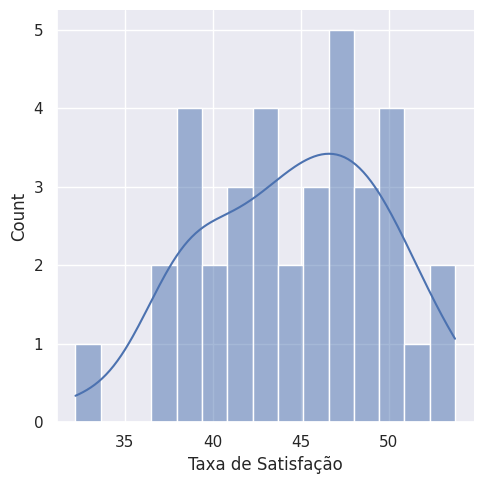

In [593]:
sns.set()
plt.clf()
plt.figure(figsize=(10, 6))
sns.displot(base_dados.iloc[:,1], kde=True, bins=15)
plt.show()

como esperado, a densidade dos dados se assemelha à normal. por isso, iremos manter o *StandardScaler* como redimensionador.

## Retreinando o algoritmo

Iremos fazer o fit com os dados de 2022 ate 2024 e prever 2025.

Num caso real pode ser melhor prever apenas o primeiro semestre e quando tivermos os dados reais, prever o segundo. As predições podem ser mais precisas.

In [594]:
lags_satisfacao25 = resultados.iloc[0,0]
lags_satisfacao25

[2, 4, 6]

In [595]:
base24_escalada= scaler.fit_transform(base_dados.iloc[:,1].to_numpy().reshape(-1,1)).flatten()

X_treino_satisfacao25, y_treino_satisfacao25 = criar_lags(base24_escalada, lags_satisfacao25)

In [596]:
grid_search.fit(X_treino_satisfacao25, y_treino_satisfacao25)
grid_search.best_params_

{'svr__C': 1, 'svr__epsilon': 0.1, 'svr__gamma': 1}

In [597]:
modelo_satisfacao25 = SVR(kernel='rbf', C=grid_search.best_params_.get('svr__C'),
                        gamma= grid_search.best_params_.get('svr__gamma'),
                        epsilon=grid_search.best_params_.get('svr__epsilon'))

modelo_satisfacao25.fit(X_treino_satisfacao25, y_treino_satisfacao25)

SVR(C=1, gamma=1)

#### Encontrando Previsões Pontuais

In [598]:
n_bootstraps = 1000
n_previsoes_fut25 = 12
datas_prev25 = pd.date_range(start="2025-01-01", periods=n_previsoes_fut25, freq="MS")

ultimos_satisfacao25 = base24_escalada[-max(lags_satisfacao):].tolist()


futuros_satisfacao25 = []

for _ in range(n_previsoes_fut25):

    input_modelo_satisfacao25 = [ultimos_satisfacao25[-lag] for lag in lags_satisfacao]

    previsao_scaled_satisfacao25 = modelo_satisfacao25.predict([input_modelo_satisfacao25])[0]

    previsao_satisfacao25 = scaler.inverse_transform(np.array(previsao_scaled_satisfacao25).reshape(-1, 1)).flatten()[0]

    futuros_satisfacao25.append(previsao_satisfacao25)

    ultimos_satisfacao25.append(previsao_scaled_satisfacao25)
    ultimos_satisfacao25.pop(0)


futuros_satisfacao25 = np.array(futuros_satisfacao25)

#### Encontrando Intervalo de Confiança

In [599]:
previsoes_bootstrap_satisfacao_25 = np.zeros((n_bootstraps, n_previsoes_fut25))


for i in range(n_bootstraps):
    X_treino25_resampled,y_treino25_resampled = resample(X_treino_satisfacao25,y_treino_satisfacao25, random_state=i)

    modelo_bootstrap_satisfacao25 = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)
    modelo_bootstrap_satisfacao25.fit(X_treino25_resampled,y_treino25_resampled)

    ultimos_satisfacao25 = base24_escalada[-max(lags_satisfacao):].tolist()
    futuros_satisfacao25_boot = []

    for _ in range(n_previsoes_fut25):
        input_modelo_satisfacao25 = [ultimos_satisfacao25[-lag] for lag in lags_satisfacao]

        previsao_scaled_satisfacao25 = modelo_bootstrap_satisfacao25.predict([input_modelo_satisfacao25])[0]
        previsao_satisfacao25 = scaler.inverse_transform(np.array(previsao_scaled_satisfacao25).reshape(-1, 1)).flatten()[0]

        futuros_satisfacao25_boot.append(previsao_satisfacao25)


        ultimos_satisfacao25.append(previsao_scaled_satisfacao25)
        ultimos_satisfacao25.pop(0)

    previsoes_bootstrap_satisfacao_25[i, :] = futuros_satisfacao25_boot

lim_inf_satisfacao25 = np.percentile(previsoes_bootstrap_satisfacao_25, 2.5, axis=0)
lim_sup_satisfacao25 = np.percentile(previsoes_bootstrap_satisfacao_25, 97.5, axis=0)




In [600]:
    grid_search.fit(X_treino25_resampled, y_treino25_resampled)
    parametros_boot = grid_search.best_params_
    print(parametros_boot)

{'svr__C': 1, 'svr__epsilon': 0.001, 'svr__gamma': 'scale'}


In [601]:
previsoes_bootstrap_satisfacao_25 = np.zeros((n_bootstraps, n_previsoes_fut25))


for i in range(n_bootstraps):
    X_treino25_resampled,y_treino25_resampled = resample(X_treino_satisfacao25,y_treino_satisfacao25, random_state=i)

    modelo_bootstrap_satisfacao25 = SVR(kernel='rbf', C= parametros_boot.get('svr__C'),
                           gamma= parametros_boot.get('svr__gamma'),
                           epsilon=parametros_boot.get('svr__epsilon'))

    modelo_bootstrap_satisfacao25.fit(X_treino25_resampled,y_treino25_resampled)

    ultimos_satisfacao25 = base24_escalada[-max(lags_satisfacao):].tolist()
    futuros_satisfacao25_boot = []

    for _ in range(n_previsoes_fut25):
        input_modelo_satisfacao25 = [ultimos_satisfacao25[-lag] for lag in lags_satisfacao]

        previsao_scaled_satisfacao25 = modelo_bootstrap_satisfacao25.predict([input_modelo_satisfacao25])[0]
        previsao_satisfacao25 = scaler.inverse_transform(np.array(previsao_scaled_satisfacao25).reshape(-1, 1)).flatten()[0]

        futuros_satisfacao25_boot.append(previsao_satisfacao25)


        ultimos_satisfacao25.append(previsao_scaled_satisfacao25)
        ultimos_satisfacao25.pop(0)

    previsoes_bootstrap_satisfacao_25[i, :] = futuros_satisfacao25_boot

lim_inf_satisfacao25 = np.percentile(previsoes_bootstrap_satisfacao_25, 2.5, axis=0)
lim_sup_satisfacao25 = np.percentile(previsoes_bootstrap_satisfacao_25, 97.5, axis=0)




In [602]:
base_previsoes25_grafico = pd.DataFrame({
    'Data':datas_prev25,
    'Dados': ["Previsões SVR com lags 2,4,6"]*len(datas_prev25),
    'Taxa de Satisfação':np.round(futuros_satisfacao25,2),
    'Lim_Inf':lim_inf_satisfacao25.tolist(),
    'Lim_Sup':lim_sup_satisfacao25.tolist()
})

In [603]:
base_25_grafico = pd.concat([base_observados_grafico,base_previsoes25_grafico],axis=0,ignore_index=True)
base_25_grafico['Data'] = pd.to_datetime(base_25_grafico['Data'],format='%m%Y')

#### Grafico 2025

In [604]:
fig = px.line(base_25_grafico, x="Data", y="Taxa de Satisfação",
              color = 'Dados')

fig.add_trace(
        go.Scatter(
            x=base_25_grafico["Data"].tolist() + base_25_grafico["Data"][::-1].tolist(),
            y=base_25_grafico["Lim_Sup"].tolist() + base_25_grafico["Lim_Inf"][::-1].tolist(),
            fill="toself",
            showlegend=True,
            hoverinfo='skip',
            name=f"Intervalo de Confiança 95%"
        )
    )

fig.update_layout(title="Histórico da Taxa de Satisfação dos Clientes na Empresa",
    xaxis_title="",
    yaxis_title="(%)",
     font=dict(size=17))

fig.show()

Vamos supor agora que sairam as últimas taxas de satisfação dos clientes de 2025, de janeiro a junho. Iremos entao comparar os resultados do primeiro semestre e em seguida atualizar as previsões

# Atualizando Previsões 2025 (1º Semestre)

## Gerando Base de Dados 2025.1

In [764]:
SEED=472393
np.random.seed(SEED)
random.seed(SEED)

periodo2 = pd.date_range(start='2025-01-01', end='2025-06-01',freq='MS')

taxa_satisfacao2 = norm.rvs(loc=43,scale=4, size=len(periodo2))
taxa_satisfacao2 = np.round(taxa_satisfacao2,2)

base_dados2 = pd.DataFrame({
   'Data' : periodo2,
   'Taxa de Satisfação' : taxa_satisfacao2,
   'Dados': ['Observados']*len(periodo2)
})


In [765]:
base_dados2

,Data,Taxa de Satisfação,Dados
0,2025-01-01,46.67,Observados
1,2025-02-01,42.42,Observados
2,2025-03-01,43.94,Observados
3,2025-04-01,43.29,Observados
4,2025-05-01,46.40,Observados
5,2025-06-01,45.27,Observados


In [766]:
base_observados_grafico2 = pd.concat([base_observados_grafico,base_dados2],axis=0,ignore_index=True)
base_observados_grafico2.tail(3)

,Data,Taxa de Satisfação,Dados
39,2025-04-01,43.29,Observados
40,2025-05-01,46.40,Observados
41,2025-06-01,45.27,Observados


## Retreinando o algoritmo

In [767]:
base_nova25_escalada= scaler.fit_transform(base_observados_grafico2.iloc[:,1].to_numpy().reshape(-1,1)).flatten()

X_treino_satisfacao_nova25, y_treino_satisfacao_nova25 = criar_lags(base_nova25_escalada, lags_satisfacao25)

grid_search.fit(X_treino_satisfacao_nova25, y_treino_satisfacao_nova25)
grid_search.best_params_

{'svr__C': 1, 'svr__epsilon': 0.2, 'svr__gamma': 'scale'}

In [768]:
modelo_satisfacao_nova25 = SVR(kernel='rbf', C=grid_search.best_params_.get('svr__C'),
                        gamma= grid_search.best_params_.get('svr__gamma'),
                        epsilon=grid_search.best_params_.get('svr__epsilon'))

modelo_satisfacao_nova25.fit(X_treino_satisfacao_nova25, y_treino_satisfacao_nova25)

SVR(C=1, epsilon=0.2)

#### Encontrando Previsões Pontuais

In [769]:
n_bootstraps = 1000
n_previsoes_fut25 = 6
datas_prev25 = pd.date_range(start="2025-07-01", periods=n_previsoes_fut25, freq="MS")

ultimos_satisfacao_nova25 = base_nova25_escalada[-max(lags_satisfacao):].tolist()


futuros_satisfacao_nova25 = []

for _ in range(n_previsoes_fut25):

    input_modelo_satisfacao_nova25 = [ultimos_satisfacao_nova25[-lag] for lag in lags_satisfacao25]

    previsao_scaled_satisfacao_nova25 = modelo_satisfacao_nova25.predict([input_modelo_satisfacao_nova25])[0]

    previsao_satisfacao_nova25 = scaler.inverse_transform(np.array(previsao_scaled_satisfacao_nova25).reshape(-1, 1)).flatten()[0]

    futuros_satisfacao_nova25.append(previsao_satisfacao_nova25)

    ultimos_satisfacao_nova25.append(previsao_scaled_satisfacao_nova25)
    ultimos_satisfacao_nova25.pop(0)


futuros_satisfacao_nova25 = np.array(futuros_satisfacao_nova25)

#### Encontrando Intervalo de Confiança

In [770]:
previsoes_bootstrap_satisfacao_25 = np.zeros((n_bootstraps, n_previsoes_fut25))


for i in range(n_bootstraps):
    X_treino_nova25_resampled,y_treino_nova25_resampled = resample(X_treino_satisfacao_nova25,y_treino_satisfacao_nova25, random_state=i)

    modelo_bootstrap_satisfacao_nova25 = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)
    modelo_bootstrap_satisfacao_nova25.fit(X_treino_nova25_resampled,y_treino_nova25_resampled)

    ultimos_satisfacao_nova25 = base_nova25_escalada[-max(lags_satisfacao):].tolist()
    futuros_satisfacao_nova25_boot = []

    for _ in range(n_previsoes_fut25):
        input_modelo_satisfacao_nova25 = [ultimos_satisfacao_nova25[-lag] for lag in lags_satisfacao25]

        previsao_scaled_satisfacao_nova25 = modelo_bootstrap_satisfacao_nova25.predict([input_modelo_satisfacao_nova25])[0]
        previsao_satisfacao_nova25 = scaler.inverse_transform(np.array(previsao_scaled_satisfacao_nova25).reshape(-1, 1)).flatten()[0]

        futuros_satisfacao_nova25_boot.append(previsao_satisfacao_nova25)


        ultimos_satisfacao_nova25.append(previsao_scaled_satisfacao_nova25)
        ultimos_satisfacao_nova25.pop(0)

    previsoes_bootstrap_satisfacao_25[i, :] = futuros_satisfacao_nova25_boot

lim_inf_satisfacao_nova25 = np.percentile(previsoes_bootstrap_satisfacao_25, 2.5, axis=0)
lim_sup_satisfacao_nova25 = np.percentile(previsoes_bootstrap_satisfacao_25, 97.5, axis=0)




In [771]:
    grid_search.fit(X_treino_nova25_resampled, y_treino_nova25_resampled)
    parametros_boot = grid_search.best_params_
    print(parametros_boot)

{'svr__C': 100, 'svr__epsilon': 0.001, 'svr__gamma': 0.01}


In [772]:
previsoes_bootstrap_satisfacao_25 = np.zeros((n_bootstraps, n_previsoes_fut25))


for i in range(n_bootstraps):
    X_treino_nova25_resampled,y_treino_nova25_resampled = resample(X_treino_satisfacao_nova25,y_treino_satisfacao_nova25, random_state=i)

    modelo_bootstrap_satisfacao_nova25 = SVR(kernel='rbf', C= parametros_boot.get('svr__C'),
                                              gamma= parametros_boot.get('svr__gamma'),
                                              epsilon=parametros_boot.get('svr__epsilon'))

    modelo_bootstrap_satisfacao_nova25.fit(X_treino_nova25_resampled,y_treino_nova25_resampled)

    ultimos_satisfacao_nova25 = base_nova25_escalada[-max(lags_satisfacao):].tolist()
    futuros_satisfacao_nova25_boot = []

    for _ in range(n_previsoes_fut25):
        input_modelo_satisfacao_nova25 = [ultimos_satisfacao_nova25[-lag] for lag in lags_satisfacao25]

        previsao_scaled_satisfacao_nova25 = modelo_bootstrap_satisfacao_nova25.predict([input_modelo_satisfacao_nova25])[0]
        previsao_satisfacao_nova25 = scaler.inverse_transform(np.array(previsao_scaled_satisfacao_nova25).reshape(-1, 1)).flatten()[0]

        futuros_satisfacao_nova25_boot.append(previsao_satisfacao_nova25)


        ultimos_satisfacao_nova25.append(previsao_scaled_satisfacao_nova25)
        ultimos_satisfacao_nova25.pop(0)

    previsoes_bootstrap_satisfacao_25[i, :] = futuros_satisfacao_nova25_boot

lim_inf_satisfacao_nova25 = np.percentile(previsoes_bootstrap_satisfacao_25, 2.5, axis=0)
lim_sup_satisfacao_nova25 = np.percentile(previsoes_bootstrap_satisfacao_25, 97.5, axis=0)




In [773]:
base_previsoes25_grafico2 = pd.DataFrame({
    'Data':datas_prev25,
    'Dados': ["Previsões Atualizadas"]*len(datas_prev25),
    'Taxa de Satisfação':np.round(futuros_satisfacao_nova25,2),
    'Lim_Inf':lim_inf_satisfacao_nova25.tolist(),
    'Lim_Sup':lim_sup_satisfacao_nova25.tolist()
})

In [774]:
base_25_grafico2 = pd.concat([base_25_grafico,base_dados2,base_previsoes25_grafico2],axis=0,ignore_index=True)


#### Grafico 2025

In [775]:
color_map = {
    'Observados': 'blue',
    'Previsões SVR com lags 2,4,6': 'red',
    'Previsões Atualizadas': 'black'
}

ic_color_map = {
    'Previsões SVR com lags 2,4,6': 'rgba(255, 0, 0, 0.2)',    # vermelho claro
    'Previsões Atualizadas': 'rgba(100, 100, 100, 0.2)',       # cinza claro
}

In [776]:

fig = px.line(base_25_grafico2, x="Data", y="Taxa de Satisfação",
              color = 'Dados',color_discrete_map=color_map)

previsoes = base_25_grafico2["Dados"].unique()

for prevs in base_25_grafico2["Dados"].unique():
    df_ic = base_25_grafico2[
        (base_25_grafico2["Dados"] == prevs) &
        base_25_grafico2["Lim_Inf"].notna() &
        base_25_grafico2["Lim_Sup"].notna()
    ]

    if not df_ic.empty:
        fig.add_trace(
            go.Scatter(
                x=df_ic["Data"].tolist() + df_ic["Data"][::-1].tolist(),
                y=df_ic["Lim_Sup"].tolist() + df_ic["Lim_Inf"][::-1].tolist(),
                fill="toself",
                fillcolor=ic_color_map.get(prevs, 'rgba(0, 0, 255, 0.2)'),
                line=dict(color='rgba(255,255,255,0)'),
                showlegend=True,
                hoverinfo='skip',
                name=f"Intervalo de Confiança 95%"
            ))

fig.update_layout(title="Histórico da Taxa de Satisfação dos Clientes na Empresa",
    xaxis_title="",
    yaxis_title="(%)",
     font=dict(size=17))

fig.show()

In [777]:
pd.DataFrame({
    'Data': base_dados2['Data'],
    'Taxa de Satisfação': base_dados2['Taxa de Satisfação'],
    'Previsão': np.round(futuros_satisfacao25[:6],2),
    'Intervalo de':np.round(lim_inf_satisfacao25[:6],2),
    'Confiança (95%)': np.round(lim_sup_satisfacao25[:6],2)
})



,Data,Taxa de Satisfação,Previsão,Intervalo de,Confiança (95%)
0,2025-01-01,46.67,39.35,37.43,41.66
1,2025-02-01,42.42,43.07,41.50,45.41
2,2025-03-01,43.94,43.49,42.15,47.14
3,2025-04-01,43.29,38.61,37.67,45.90
4,2025-05-01,46.40,44.05,42.18,50.15
5,2025-06-01,45.27,42.98,38.71,45.28


In [778]:
rmse_prev25 = root_mean_squared_error(base_dados2.iloc[:,1],futuros_satisfacao25[:6])

mae_prev25 = mean_absolute_error(base_dados2.iloc[:,1],futuros_satisfacao25[:6])

print('RMSE Previsão lags 2,4,6: %.2f' % rmse_prev25)
print('MAE Previsão lags 2,4,6: %.2f' % mae_prev25)


RMSE Previsão lags 2,4,6: 3.80
MAE Previsão lags 2,4,6: 2.96
